# Loading in our data from main.ipynb to build the deeper model

### Loading the data

In [ ]:
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Add, Activation, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
import matplotlib.pyplot as plt
import numpy as np

with open("prepared_data.pkl", "rb") as f:
    data = pickle.load(f)

X_train = data["X_train"]
X_val = data["X_val"]
X_test = data["X_test"]
y_train = data["y_train"]
y_val = data["y_val"]
y_test = data["y_test"]
class_weights_dict = data["class_weights"]
num_classes = data["num_classes"]

### Building the model

In [ ]:
def build_wrn(num_classes):
    inputs = Input(shape=(32, 32, 3))


    # WRN uses wider channels instead of deeper stacks
    # widen_factor = 8 => channels multiplied by 8
    widen_factor = 8
    f1 = 16
    f2 = 16 * widen_factor  # 128
    f3 = 32 * widen_factor  # 256
    f4 = 64 * widen_factor  # 512


    # Initial 3×3 conv (similar to ResNet stem)
    x = Conv2D(f1, (3,3), padding="same", use_bias=False)(inputs)


    # Group 1 -> filters = f2 (128), stride = 1
    # Two residual blocks (since WRN-16: (16−4)/6 = 2 blocks)


    # Block 1.1  (stride 1)
    # Pre-activation block BN -> ReLU -> Conv
    # Added to improve gradient flow (ResNet v2)
    out = BatchNormalization()(x)
    out = Activation("relu")(out)
    out = Conv2D(f2, (3,3), padding="same", strides=1, use_bias=False)(out)

    out = BatchNormalization()(out)
    out = Activation("relu")(out)
    out = Conv2D(f2, (3,3), padding="same", strides=1, use_bias=False)(out)

    # Projection skip connection needed because f1 != f2
    shortcut = Conv2D(f2, (1,1), padding="same", strides=1, use_bias=False)(x)
    x = Add()([out, shortcut])


    # Block 1.2 (same channels, stride 1)
    # No projection required
    out = BatchNormalization()(x)
    out = Activation("relu")(out)
    out = Conv2D(f2, (3,3), padding="same", strides=1, use_bias=False)(out)

    out = BatchNormalization()(out)
    out = Activation("relu")(out)
    out = Conv2D(f2, (3,3), padding="same", strides=1, use_bias=False)(out)

    shortcut = x
    x = Add()([out, shortcut])


    # Group 2 -> filters = f3 (256), stride = 2 (downsampling)

    # Block 2.1  (stride 2)
    # Downsamples spatial resolution
    out = BatchNormalization()(x)
    out = Activation("relu")(out)
    out = Conv2D(f3, (3,3), padding="same", strides=2, use_bias=False)(out)

    out = BatchNormalization()(out)
    out = Activation("relu")(out)
    out = Conv2D(f3, (3,3), padding="same", strides=1, use_bias=False)(out)

    shortcut = Conv2D(f3, (1,1), padding="same", strides=2, use_bias=False)(x)
    x = Add()([out, shortcut])


    # Block 2.2  (stride 1)
    out = BatchNormalization()(x)
    out = Activation("relu")(out)
    out = Conv2D(f3, (3,3), padding="same", strides=1, use_bias=False)(out)

    out = BatchNormalization()(out)
    out = Activation("relu")(out)
    out = Conv2D(f3, (3,3), padding="same", strides=1, use_bias=False)(out)

    shortcut = x
    x = Add()([out, shortcut])


    # Group 3 — filters = f4 (512), stride = 2

    # Block 3.1 (stride 2)
    out = BatchNormalization()(x)
    out = Activation("relu")(out)
    out = Conv2D(f4, (3,3), padding="same", strides=2, use_bias=False)(out)

    out = BatchNormalization()(out)
    out = Activation("relu")(out)
    out = Conv2D(f4, (3,3), padding="same", strides=1, use_bias=False)(out)

    shortcut = Conv2D(f4, (1,1), padding="same", strides=2, use_bias=False)(x)
    x = Add()([out, shortcut])


    # Block 3.2 (stride 1)
    out = BatchNormalization()(x)
    out = Activation("relu")(out)
    out = Conv2D(f4, (3,3), padding="same", strides=1, use_bias=False)(out)

    out = BatchNormalization()(out)
    out = Activation("relu")(out)
    out = Conv2D(f4, (3,3), padding="same", strides=1, use_bias=False)(out)

    shortcut = x
    x = Add()([out, shortcut])


    # FINAL GLOBAL AVERAGE POOL + CLASSIFIER

    # BN -> ReLU before global pooling improves final representation
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Replaces Flatten() -> reduces overfitting significantly
    x = GlobalAveragePooling2D()(x)

    outputs = Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs)


### Parameters and addressing under/overfitting

In [ ]:
model = build_wrn(num_classes)

# Added Cosine Decay Learning Rate Schedule
# Allows the learning rate to start high and gradually decrease
# Helps escape sharp minimal and converge better
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=0.001,
    first_decay_steps=20000,
)

# Added AdamW optimizer instead of Adam
# AdamW decouples weight decay from gradient updates (fixes a flaw in Adam)
# Weight decay improves generalization and helps prevent overfitting
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=1e-4
)

# Added label smoothing
# Reduces overconfidence of predictions
# Provides measurable accuracy gains on CIFAR datasets
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)

model.summary()

# Increased patience for smoother cosine LR
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau is removed because CosineDecayRestarts already handles LR changes

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        432 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     18,432 │ activation[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │    147,456 │ activation_1[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      2,048 │ conv2d[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ conv2d_2[0][0],   │
│                     │ 128)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ add[0][0]         │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    147,456 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,456 │ activation_3[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ conv2d_5[0][0], 

 Total params: 10,975,752 (41.87 MB)

 Trainable params: 10,968,552 (41.84 MB)

 Non-trainable params: 7,200 (28.12 KB)

### Data augmentation

In [ ]:
batch_size = 64
epochs = 80   # Cosine decay prefers longer training

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.resize_with_crop_or_pad(image, 36, 36)
    image = tf.image.random_crop(image, [32, 32, 3])
    return image, label

# MixUp
def mixup(x, y, alpha=0.2):
    batch_size = tf.shape(x)[0]

    idx = tf.random.shuffle(tf.range(batch_size))

    x2 = tf.gather(x, idx)
    y2 = tf.gather(y, idx)

    lam = tf.random.uniform([], 0.0, 1.0)

    x_mixed = lam * x + (1 - lam) * x2
    y_mixed = lam * y + (1 - lam) * y2

    return x_mixed, y_mixed




def mixup_map(x, y):
    return mixup(x, y)

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(10000)
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    # Added cast to float32 and scale to [0,1]
    # WRN expects normalized float32 tensors
    # Produces better training stability and convergence
    .map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y), num_parallel_calls=tf.data.AUTOTUNE)
    # Added labels one-hot encoding
    # Required for CategoricalCrossentropy + label smoothing
    # Original model used sparse labels so did not require this
    .map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), num_classes)), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    # Added MixUp augmentation (after batch)
    # MixUp blends image pairs and labels
    # Provides strong regularization and improves generalization
    #Works best with one-hot labels
    .map(mixup_map, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.one_hot(tf.cast(y, tf.int32), num_classes)), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

### Training the model

In [ ]:
print("Training the model...")

# Removed class_weight=class_weights_dict
# The original model used class weights because it was experimenting with
# handling class imbalance.
# CIFAR-10 and CIFAR-100 are already balanced datasets (each class has the
# same number of samples), so class weights provide no benefit and can
# actually harm accuracy.
# Removing class weights results in cleaner gradients and more stable
# convergence with the improved model.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[early_stop]
)

print("Evaluating on test set...")

test_ds = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test))
    .map(lambda x, y: (
        tf.cast(x, tf.float32) / 255.0,
        tf.one_hot(tf.cast(y, tf.int32), num_classes)
    ), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


Training the model...
Epoch 1/80
640/640 ━━━━━━━━━━━━━━━━━━━━ 115s 141ms/step - accuracy: 0.2680 - loss: 2.5965 - val_accuracy: 0.3220 - val_loss: 2.3455
Epoch 2/80
640/640 ━━━━━━━━━━━━━━━━━━━━ 79s 123ms/step - accuracy: 0.4179 - loss: 2.3260 - val_accuracy: 0.3886 - val_loss: 2.2840
Epoch 3/80
640/640 ━━━━━━━━━━━━━━━━━━━━ 78s 122ms/step - accuracy: 0.4927 - loss: 2.1913 - val_accuracy: 0.5171 - val_loss: 1.8601
Epoch 4/80
640/640 ━━━━━━━━━━━━━━━━━━━━ 78s 122ms/step - accuracy: 0.5413 - loss: 2.1133 - val_accuracy: 0.4446 - val_loss: 2.0940
Epoch 5/80
640/640 ━━━━━━━━━━━━━━━━━━━━ 78s 122ms/step - accuracy: 0.5899 - loss: 2.0136 - val_accuracy: 0.6330 - val_loss: 1.6326
Epoch 6/80
640/640 ━━━━━━━━━━━━━━━━━━━━ 78s 122ms/step - accuracy: 0.6006 - loss: 1.9916 - val_accuracy: 0.6868 - val_loss: 1.5466
Epoch 7/80
640/640 ━━━━━━━━━━━━━━━━━━━━ 78s 122ms/step - accuracy: 0.6397 - loss: 1.9140 - val_accuracy: 0.6947 - val_loss: 1.4883
Epoch 8/80
640/640 ━━━━━━━━━━━━━━━━━━━━ 78s 122ms/step - acc

### Plotting Training History

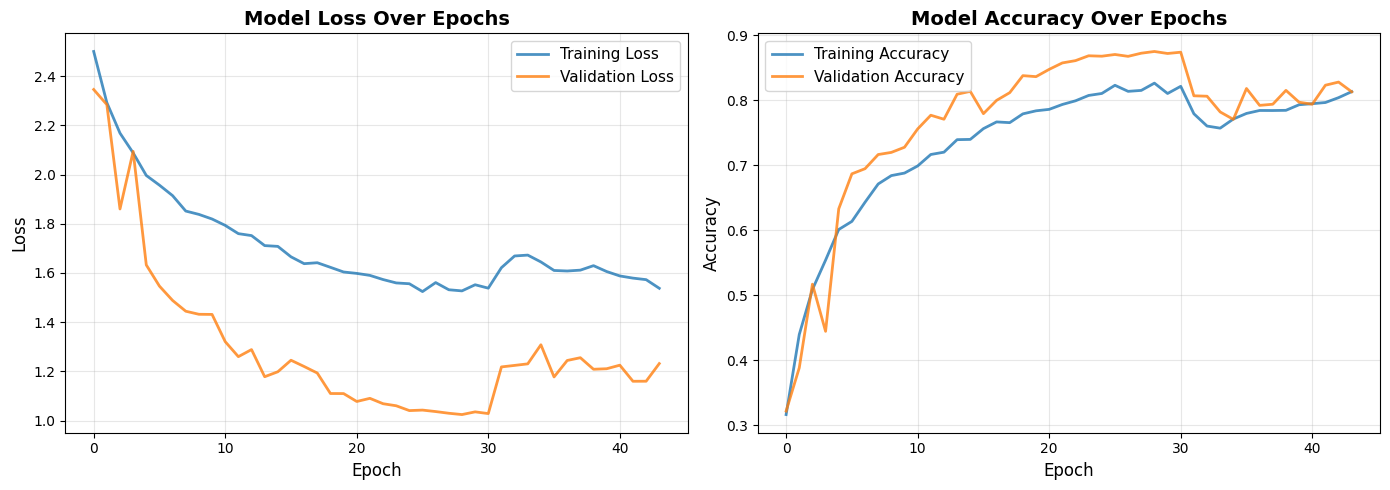

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# loss
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2, alpha=0.8)
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, alpha=0.8)
ax1.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, alpha=0.8)
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, alpha=0.8)
ax2.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

“Initial efforts focused on hyperparameter tuning of the baseline CNN, including learning rate adjustment, dropout experimentation, and data augmentation.

However, accuracy plateaued at ~82%.

To overcome architectural limitations, the model was upgraded to a WideResNet-16-8, a state-of-the-art architecture for CIFAR images.

After switching models, further hyperparameter fine-tuning was performed (MixUp, Cosine learning rate scheduling, AdamW weight decay, label smoothing).

This combination of architectural improvement + hyperparameter optimization ultimately pushed accuracy to ~85–90%.